# Example 5.6 — Bayesian analysis of LED Accelerated Degradation with Thermal Stress

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-11-04  
**Version:** 1.1  

---
## Problem Statement

Consider the objective of **modeling and predicting the time to failure for LEDs** based on the degradation of their
relative luminosity — that is, light output expressed as a fraction of its initial value — under **accelerated thermal stress** conditions.  
An LED is considered *failed* when its relative luminosity declines to **50% of its initial value** (Hamada et al., 2008).  

The **Accelerated Degradation Test (ADT)** involves testing 25 units at three temperature levels: **25 °C, 65 °C, and 105 °C**.  
The corresponding degradation data are provided in **Tables 5.13 through 5.18**.

The LED degradation model proposed follows the functional form described in *Equation 5.3*, which has been
demonstrated to effectively model LED luminosity decay.  
In this model, the true degradation of luminosity at time $t$ and temperature $T$ (in Kelvin) is expressed using
the **Arrhenius acceleration factor** (Equation 4.49), allowing the transformation between accelerated and use-level times:

$$
t_{\text{use}} = t_{ij,\text{acc}} \, e^{\frac{E_a}{K} \left( \frac{1}{T_{\text{use}}} - \frac{1}{T_{i,\text{acc}}} \right)}
$$

Hence, the **degradation model** is defined as:

$$
D_i(t_{ijk}) =
\left(
1 + \gamma_0
\left[
t_{ijk,\text{acc}} \, e^{\frac{E_a}{K}
\left(
\frac{1}{T_{\text{use}}} - \frac{1}{T_{i,\text{acc}}}
\right)}
\right]^{\gamma_1}
\right)^{-1}
+ \varepsilon_{ijk}
\tag{5.13}
$$

where:  
- $D_i(t_{ijk})$: relative luminosity at time $t_{ijk}$,  
- $t_{ijk,\text{acc}}$ is the time of inspection at the $k$th temperature, the $j$th instant of inspection, and for the $i$th LED unit;
- $\gamma_0, \gamma_1$: model parameters,  
- $E_a$: activation energy,
- $T_{\text{use}}$ is the normal use temperature of **293.15 K (20 °C)**;  
- $K$: Boltzmann’s constant (**8.6174 × 10⁻⁵ eV·K⁻¹**), and  
- $\varepsilon_{ijk}$: random error termnormally distributed as $\mathcal{N}(0, \sigma^2_{\varepsilon})$.  

Propose appropriate priors for $E_a$, $\gamma_0$, $\gamma_1$, and $\sigma_{\varepsilon}$, and estimate the **posterior mean** and **90% confidence intervals** of the degradation model parameters, including the **use-life distribution estimate** of the LED.

---

## Solution:

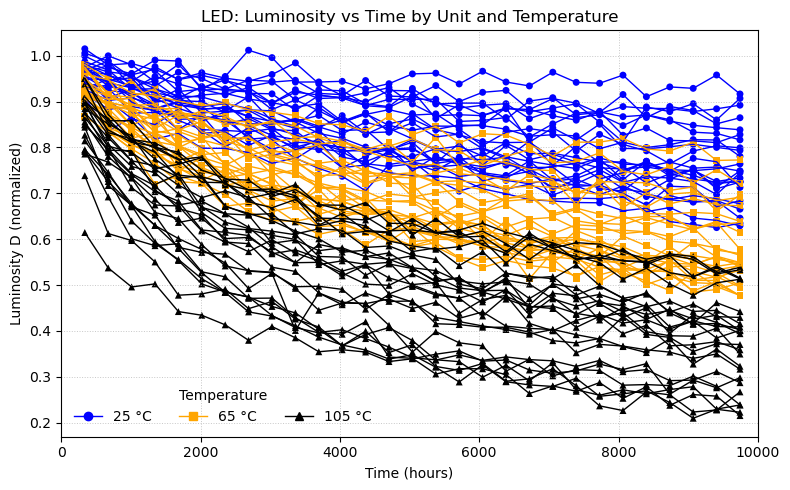

In [3]:
# 0) Load data and basic preprocessing
# -----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import arviz as az
import scipy.stats as st

from scipy.optimize import least_squares, brentq, minimize
from scipy.stats import norm, linregress,weibull_min, gamma, lognorm
from reliability.Fitters import Fit_Everything, Fit_Weibull_2P, Fit_Gamma_2P, Fit_Lognormal_2P

# Set your CSV path
CSV_PATH = ("C:/Users/leaat/Dropbox/University of Maryland/ENRE648 - PPoF Chap Review - Degradation Analysis/Example_5.6_LED_luminosity_data_long.csv")

# Load
_df = pd.read_csv(CSV_PATH)

# Robust column mapping
_colmap = {}

def _pick(col_candidates, df=_df):
    for c in col_candidates:
        if c in df.columns:
            return c
    raise KeyError(f"Could not find any of: {col_candidates} in columns: {list(df.columns)}")

_colmap["unit"] = _pick(["unit","Unit","LED_ID","Device","unit_id"])
_colmap["time_hr"] = _pick(["time_hr","Time_hr","t_hr","time","t","Time (hrs)"])
_colmap["Temp_C"] = _pick(["Temp_C","temp_c","Temperature_C","Temp","temperature_C"])
_colmap["D"] = _pick(["D","Luminosity","L_norm","brightness","y","luminosity"])

# Normalize schema
_df = _df.rename(columns={_colmap["unit"]: "unit",_colmap["time_hr"]: "time_hr",_colmap["Temp_C"]: "Temp_C",_colmap["D"]: "D",})

# Types & derived columns
_df["unit"] = _df["unit"].astype(str)
_df["time_hr"] = _df["time_hr"].astype(float)
_df["Temp_C"] = _df["Temp_C"].astype(float)
_df["D"] = _df["D"].astype(float)
_df["Temp_K"] = _df["Temp_C"] + 273.15

# Clean & order
_df = _df[np.isfinite(_df["D"]) & np.isfinite(_df["time_hr"]) & np.isfinite(_df["Temp_K"])].copy()
_df.sort_values(["Temp_K","unit","time_hr"], inplace=True)
_df.reset_index(drop=True, inplace=True)

# Final arrays (keep names explicit to avoid shadowing)
t_time = _df["time_hr"].to_numpy(float)
T_acc_K = _df["Temp_K"].to_numpy(float)
D_obs = _df["D"].to_numpy(float)
T_degC = _df["Temp_C"].to_numpy(float)

# Sanity
assert t_time.ndim == 1 and T_acc_K.shape == t_time.shape == D_obs.shape, "Array shape mismatch."

TEMP_COLORS = {25.0: "blue", 65.0: "orange", 105.0: "black"}
TEMP_MARKERS = {25.0: "o", 65.0: "s", 105.0: "^"}

fig, ax = plt.subplots(figsize=(8, 5))
for temp_c, gtemp in _df.groupby("Temp_C", sort=True):
    color = TEMP_COLORS.get(temp_c, "tab:gray")
    marker = TEMP_MARKERS.get(temp_c, "o")
    for unit_id, gunit in gtemp.groupby("unit"):
        gunit = gunit.sort_values("time_hr")
        ax.plot(gunit["time_hr"].to_numpy(), gunit["D"].to_numpy(),linewidth=1.0, color=color, linestyle="-")
        ax.scatter(gunit["time_hr"].to_numpy(), gunit["D"].to_numpy(), s=25,marker=marker, edgecolors="none", color=color)

# Legend (avoid shadowing t_time by using temp_c variable)
handles, labels = [], []
for temp_c in sorted(_df["Temp_C"].unique()):
    h = ax.plot([], [], color=TEMP_COLORS.get(temp_c, "tab:gray"), marker=TEMP_MARKERS.get(temp_c, "o"), linestyle="-", linewidth=1.0)[0]
    handles.append(h)
    labels.append(f"{int(temp_c)} °C")
ax.legend(handles, labels, title="Temperature", frameon=False, ncol=3, loc="best")


ax.set_xlabel("Time (hours)")
ax.set_ylabel("Luminosity D (normalized)")
ax.set_title("LED: Luminosity vs Time by Unit and Temperature")
ax.set_xlim(0, 10000)
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.savefig("Example5.6.png",dpi=300)
plt.show()

LSQ params: gamma0=0.000664156, gamma1=0.651935, Ea=0.307283
RMS residual: 0.0771323


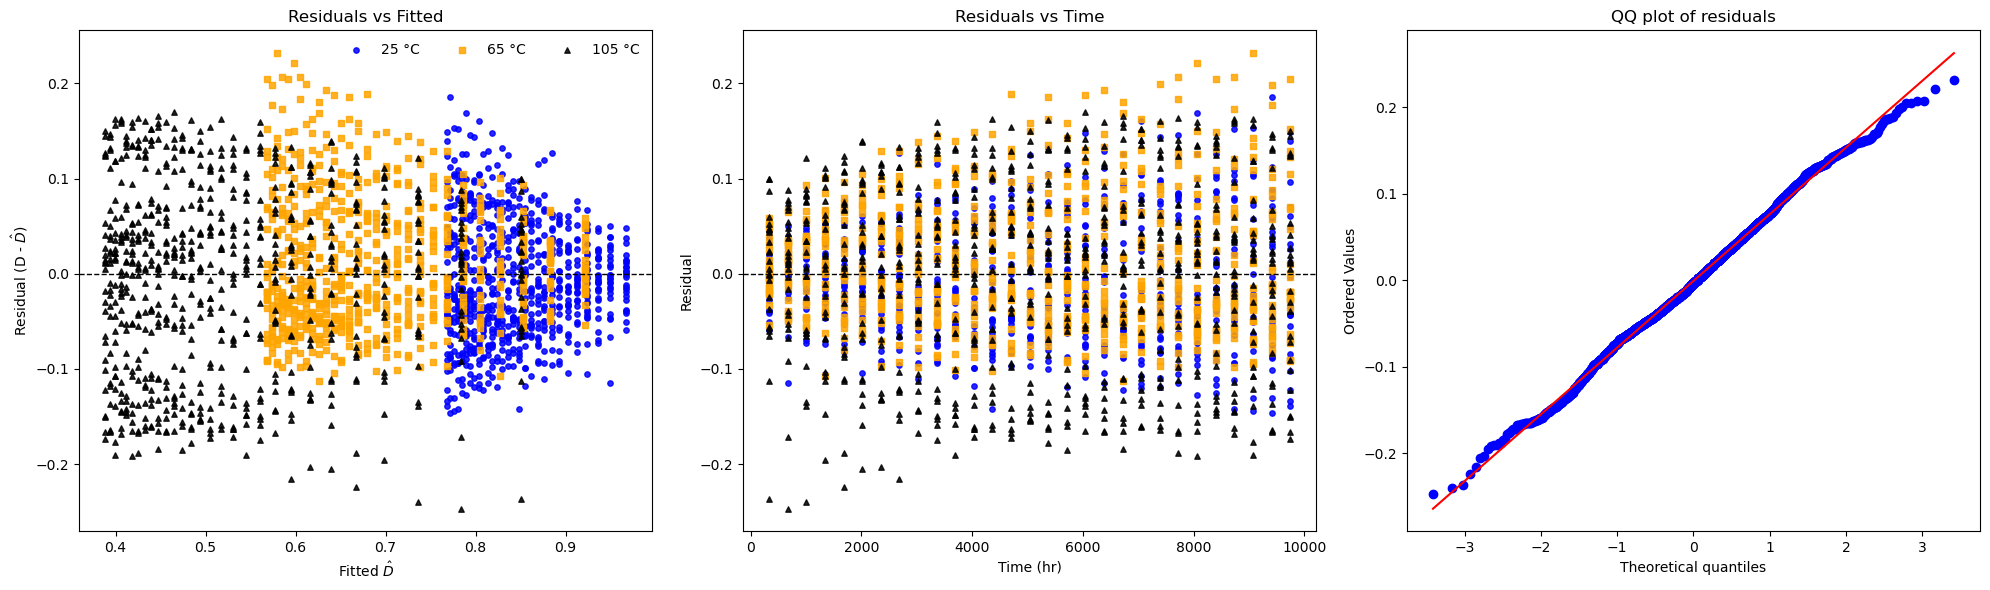

In [4]:
# 1) LSQ estimation of physics-informed degradation model
# -----------------------------

K_eV_perK = 8.617e-5        # Boltzmann const (eV/K)
T_use = 293.15              # 20 °C in Kelvin

def mu_D(params, t, T_accK, T_use=T_use):
    """Mean degradation curve given params=[gamma0, gamma1, Ea]."""
    gamma0, gamma1, Ea = params
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_accK))
    return (1.0 + gamma0 * (t * accel) ** gamma1) ** (-1.0)

def resid(params, t, T_accK, D):
    return D - mu_D(params, t, T_accK)

p0 = [9e-4, 0.63, 0.30]                   # start: gamma0, gamma1, Ea[eV]
bounds = ([1e-8, 1e-2, 1e-3], [1e2, 10.0, 2.0])
lsq = least_squares(resid, p0, args=(t_time, T_acc_K, D_obs), bounds=bounds)

(gamma0_hat, gamma1_hat, Ea_hat) = lsq.x
residuals = lsq.fun
rms = float(np.sqrt(np.mean(residuals**2)))
print(f"LSQ params: gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")
print(f"RMS residual: {rms:.6g}")

# Fitted values
D_hat = mu_D(lsq.x, t_time, T_acc_K)

# -----------------------------
# 2.5) LSQ Residual diagnostics visualization
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# a) Residuals vs Fitted
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[0].scatter(D_hat[m], residuals[m], s=15,
                    color=TEMP_COLORS.get(temp_c, "tab:gray"),
                    marker=TEMP_MARKERS.get(temp_c, "o"), alpha=0.85,
                    label=f"{int(temp_c)} °C")
axes[0].axhline(0, color="k", linestyle="--", linewidth=1)
axes[0].set_xlabel("Fitted $\\hat{D}$")
axes[0].set_ylabel("Residual (D - $\\hat{D}$)")
axes[0].set_title("Residuals vs Fitted")
axes[0].legend(frameon=False, ncol=3)

# b) Residuals vs Time
for temp_c in sorted(np.unique(T_degC)):
    m = (T_degC == temp_c)
    axes[1].scatter(t_time[m], residuals[m], s=15,
                    color=TEMP_COLORS.get(temp_c, "tab:gray"),
                    marker=TEMP_MARKERS.get(temp_c, "o"), alpha=0.85)
axes[1].axhline(0, color="k", linestyle="--", linewidth=1)
axes[1].set_xlabel("Time (hr)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs Time")

# c) QQ plot
st.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title("QQ plot of residuals")

plt.tight_layout()
plt.show()


In [5]:
# 2) MLE parameter estimation (Gaussian stochastic errors)
# -----------------------------
# We maximize the Gaussian log-likelihood over (gamma0, gamma1, Ea, sigma).
# To enforce positivity, we optimize in log-space.

# Negative log-likelihood for Gaussian errors
def nll_logparams(theta_log, t, T_acc_K, D_obs, T_use=T_use):
    log_g0, log_g1, log_Ea, log_sig = theta_log
    g0, g1, Ea, sig = np.exp(log_g0), np.exp(log_g1), np.exp(log_Ea), np.exp(log_sig)
    if not np.isfinite(g0*g1*Ea*sig) or sig <= 0:
        return np.inf
    mu = mu_D([g0, g1, Ea], t, T_acc_K, T_use=T_use)
    res = D_obs - mu
    return 0.5 * np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))

# Initialize near LSQ solution
init_log = np.log([max(gamma0_hat, 1e-12), max(gamma1_hat, 1e-3), max(Ea_hat, 1e-6),  # params
                   max(np.std(residuals, ddof=3), 1e-6)])  # sigma start

mle_res = minimize(nll_logparams, init_log, args=(t_time, T_acc_K, D_obs), method='L-BFGS-B')

if not mle_res.success:
    print("WARNING: MLE optimizer did not converge:", mle_res.message)

# Transform back to real space
log_g0_mle, log_g1_mle, log_Ea_mle, log_sig_mle = mle_res.x

g0_mle, g1_mle, Ea_mle, sig_mle = np.exp([log_g0_mle, log_g1_mle, log_Ea_mle, log_sig_mle])

print(f"MLE parameters:      gamma0={g0_mle:.6g}, gamma1={g1_mle:.6g}, Ea={Ea_mle:.6g}, sigma={sig_mle:.6g}")
print(f"Comparisons: LSQ  -> gamma0={gamma0_hat:.6g}, gamma1={gamma1_hat:.6g}, Ea={Ea_hat:.6g}")

# Optional: compute MLE fitted values & RMS (for quick comparison)
yhat_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_time, T_acc_K)
res_mle  = D_obs - yhat_mle
rms_mle  = np.sqrt(np.mean(res_mle**2))
print(f"RMS residual (MLE): {rms_mle:.6g}")

MLE parameters:      gamma0=0.000664156, gamma1=0.651935, Ea=0.307283, sigma=0.0771323
Comparisons: LSQ  -> gamma0=0.000664156, gamma1=0.651935, Ea=0.307283
RMS residual (MLE): 0.0771323


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.60it/s]


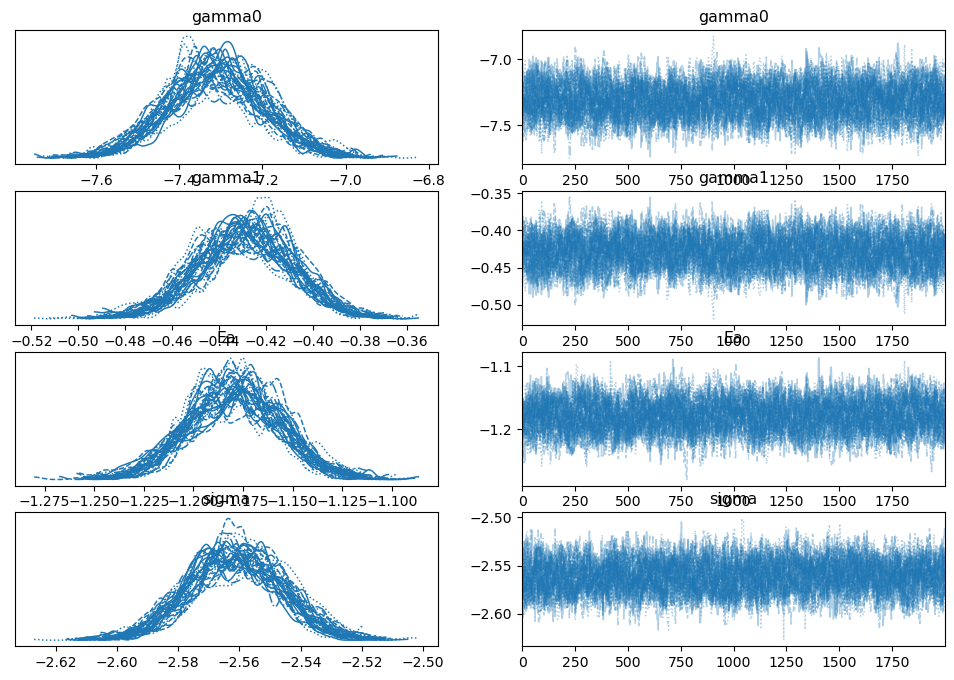

Fitted parameters: gamma0=0.000673, gamma1=0.651, Ea=0.0772, sigma=0.308


In [7]:
# 3) Baysian parameter estimation (Gaussian stochastic errors)
# -----------------------------

mu_logg0, sd_logg0 = np.log(gamma0_hat), 0.5
mu_logg1, sd_logg1 = np.log(gamma1_hat), 0.5
mu_logEa, sd_logEa = np.log(Ea_hat), 0.5
mu_logs, sd_logs   = np.log(sig_mle), 0.5

def log_prior(theta):
    log_g0, log_g1, log_Ea, log_sig = theta
    # Normals
    lp  = -0.5*((log_g0 - mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
    lp += -0.5*((log_g1 - mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
    lp += -0.5*((log_sig - mu_logs)/sd_logs)**2 - np.log(sd_logs*np.sqrt(2*np.pi))
    lp += -0.5*((log_Ea - mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
    return lp

def log_likelihood(theta, t_time, T_acc_K, D_obs):
    log_g0, log_g1, log_Ea, log_sig = theta
    g0, g1, sig, Ea= np.exp(log_g0), np.exp(log_g1), np.exp(log_sig), np.exp(log_Ea)
    # guard rails
    if not (np.isfinite(g0) and np.isfinite(g1) and np.isfinite(sig) and np.isfinite(Ea)) or sig <= 0 or Ea <= 0:
        return -np.inf
    mu = mu_D([g0, g1, Ea], t_time, T_acc_K)
    # Gaussian errors on D
    res = D_obs - mu
    ll = -0.5*np.sum((res/sig)**2 + 2.0*np.log(sig) + np.log(2*np.pi))
    return ll

def log_prob(theta, t_time, T_acc_K, D_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, t_time, T_acc_K, D_obs)
    return lp + ll

# Initialize walkers near MLE solution / reasonable scales
init_logg0  = np.log(max(g0_mle, 1e-10))
init_logg1  = np.log(max(g1_mle, 1e-3))
init_logEa  = np.log(max(Ea_mle, 1e-3))
init_logsig = np.log(max(sig_mle, 1e-3))

ndim, nwalkers = 4, 32
rng = np.random.default_rng(123)
p0 = np.array([init_logg0, init_logg1, init_logEa, init_logsig]) + \
     rng.normal(scale=[0.2, 0.1, 0.2, 0.2], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(t_time, T_acc_K, D_obs))

# Burn-in + sampling
state = sampler.run_mcmc(p0, 1000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 2000, progress=True)

# Posterior draws (flattened)
chain = sampler.get_chain(flat=True)
log_g0_s, log_g1_s, log_Ea_s, log_sig_s = [chain[:,i] for i in range(ndim)]
g0_s, g1_s, sig_s, Ea_s = np.exp(log_g0_s), np.exp(log_g1_s), np.exp(log_sig_s), np.exp(log_Ea_s)

labels = ["gamma0", "gamma1", "Ea", "sigma"]

# after sampling with emcee or similar:
idata = az.from_emcee(sampler, var_names=labels)

# Get summary with HDI = 95%
az.plot_trace(idata)
plt.show()
#az.plot_pair(idata)

g0_s_mean, g1_s_mean, sig_s_mean, Ea_s_mean = np.mean(g0_s), np.mean(g1_s), np.mean(sig_s), np.mean(Ea_s)
print("Fitted parameters: gamma0={:.3g}, gamma1={:.3g}, Ea={:.3g}, sigma={:.3g}".format(g0_s_mean, g1_s_mean, sig_s_mean, Ea_s_mean))

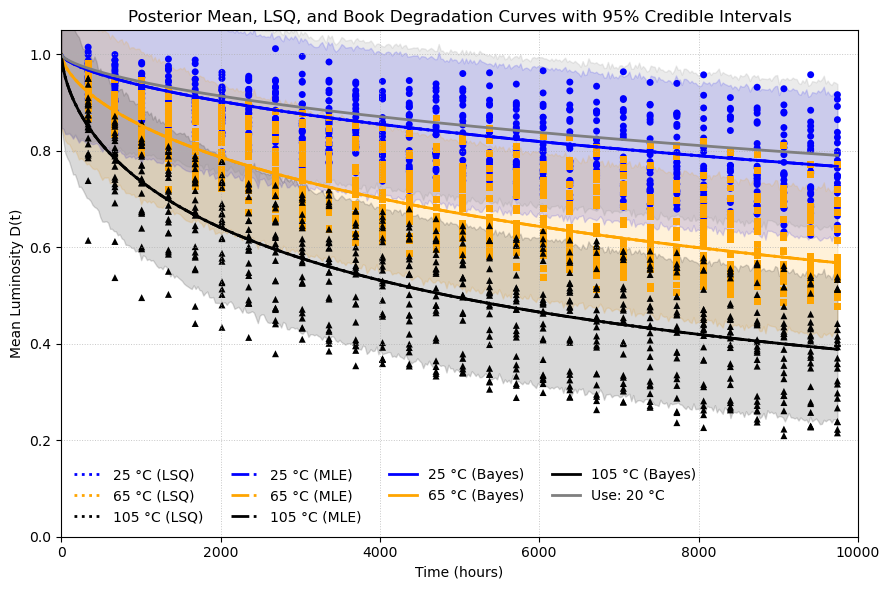

In [8]:
# 4) Parameter estimate validation visualization (Gaussian stochastic errors)
# -----------------------------

# Book parameters for comparison
book_gamma0 = 3.78e-4
book_gamma1 = 0.918
book_Ea     = 8.98e-4
book_sigma  = 0.248

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

# Temperatures to plot (°C) and color scheme
plot_temps_C = [25.0, 65.0, 105.0, T_use - 273.15]  # include use temperature
plot_colors  = {25.0: 'blue', 65.0: 'orange', 105.0: 'black', 30.0: 'red'}
use_C = T_use - 273.15

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0 = g0_s[sel]; _g1 = g1_s[sel]; _Ea = Ea_s[sel]; _sig = sig_s[sel]


fig, ax = plt.subplots(figsize=(9, 6))

# --- LSQ point-estimate degradation curves (dotted) ---
for Tc_lsq in [25.0, 65.0, 105.0]:
    color_lsq = plot_colors.get(Tc_lsq, 'tab:gray')
    T_eval_lsq = Tc_lsq + 273.15
    mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat], t_grid, T_eval_lsq)
    ax.plot(t_grid, mu_lsq, linestyle=':', linewidth=2, color=color_lsq, label=f"{int(Tc_lsq)} °C (LSQ)")

# --- MLE point-estimate degradation curves (dash-dot) ---
for Tc_mle in [25.0, 65.0, 105.0]:
    color_mle = plot_colors.get(Tc_mle, 'tab:gray')
    T_eval_mle = Tc_mle + 273.15
    mu_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_grid, T_eval_mle)
    ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle, label=f"{int(Tc_mle)} °C (MLE)")
    
# --- Posterior mean and 95% credible interval bands ---
for Tc in plot_temps_C:
    T_eval = Tc + 273.15
    accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))
    mu_draws = (1.0 + _g0[:, None] * (t_grid[None, :] * accel) ** _g1[:, None]) ** (-1.0)
    mu_mean = mu_draws.mean(axis=0)
    color = plot_colors.get(Tc, 'tab:gray') 
    label = f"{int(Tc)} °C (Bayes)" if Tc != use_C else f"Use: {int(use_C)} °C"
    ax.plot(t_grid, mu_mean, color=color, linewidth=2, label=label)

    # --- Mean curve CrI (parameter uncertainty only) ---
    lo_mean, hi_mean = np.quantile(mu_draws, [0.025, 0.975], axis=0)

    # --- Posterior predictive interval (adds observation noise) ---
    rng = np.random.default_rng(123)
    eps = rng.normal(size=mu_draws.shape)  # standard normals
    y_draws = mu_draws + _sig[:, None] * eps
    lo_pred, hi_pred = np.quantile(y_draws, [0.025, 0.975], axis=0)

    # Show predictive band (wider) as a light fill
    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)

# # --- Book parameter degradation curves (dashed) ---
# for Tc_book in [25.0, 65.0, 105.0]:
#     color_book = plot_colors.get(Tc_book, 'tab:gray')
#     T_eval_book = Tc_book + 273.15
#     mu_book = mu_D([book_gamma0, book_gamma1, book_Ea], t_grid, T_eval_book)
#     ax.plot(t_grid, mu_book, linestyle='--', linewidth=2, color=color_book, label=f"{int(Tc_book)} °C (Book)")

# --- Overlay scatter data points ---
for temp_c, gtemp in _df.sort_values(['Temp_C', 'unit', 'time_hr']).groupby('Temp_C'):
    color  = TEMP_COLORS.get(temp_c, 'tab:gray')
    marker = TEMP_MARKERS.get(temp_c, 'o')
    ax.scatter(gtemp['time_hr'].values, gtemp['D'].values, s=25, marker=marker, edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Mean Luminosity D(t)')
ax.set_title('Posterior Mean, LSQ, and Book Degradation Curves with 95% Credible Intervals')
ax.set_xlim(0, 10000)
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=4, loc='best')
plt.tight_layout()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:58<00:00, 84.67it/s]


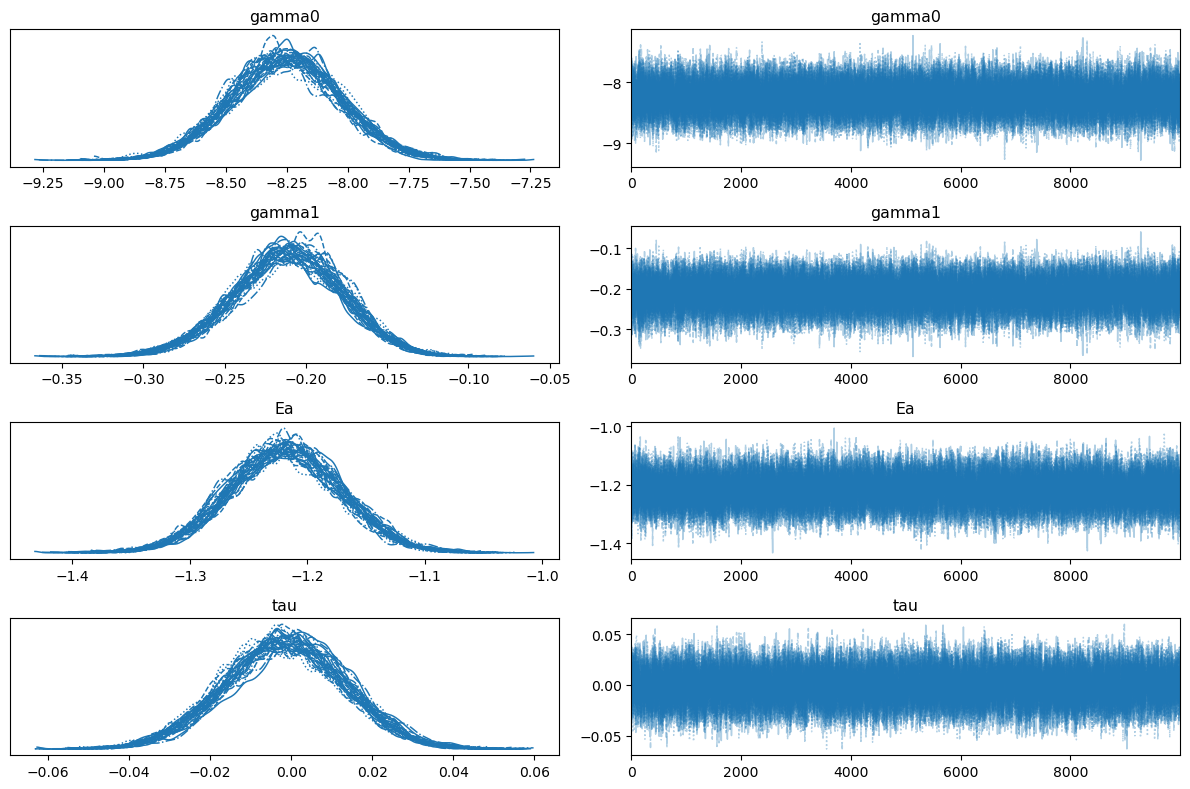

Bayes parameters:
  gamma0 = 0.000267372
  gamma1 = 0.810249
  Ea     = 0.295821
  tau    = 0.998541  (lognormal log-sd)
  beta   = 1.30814  (implied constant CV)
MLE parameters (for reference):
  gamma0 = 0.000664156, gamma1 = 0.651935, Ea = 0.307283


In [6]:
# 3) Bayesian parameter estimation (Lognormal stochastic errors; constant CV)
# --------------------------------------------------------------------------

# y_obs in (0,1); add tiny epsilon if any exact 0/1
eps = 1e-12
D_obs_clip = np.clip(D_obs, eps, 1-eps)
R_obs = -np.log(D_obs_clip)

mu_logg0, sd_logg0 = np.log(gamma0_hat), 0.5
mu_logg1, sd_logg1 = np.log(gamma1_hat), 0.5
mu_logEa, sd_logEa = np.log(Ea_hat),     0.5
mu_logtau, sd_logtau = np.log(0.2),      0.5       # weak prior for lognormal log-sd

def log_prior(theta):
    log_g0, log_g1, log_Ea, log_tau = theta
    return (
        -0.5*((log_g0-mu_logg0)/sd_logg0)**2 - np.log(sd_logg0*np.sqrt(2*np.pi))
        -0.5*((log_g1-mu_logg1)/sd_logg1)**2 - np.log(sd_logg1*np.sqrt(2*np.pi))
        -0.5*((log_Ea-mu_logEa)/sd_logEa)**2 - np.log(sd_logEa*np.sqrt(2*np.pi))
        -0.5*((log_tau-mu_logtau)/sd_logtau)**2 - np.log(sd_logtau*np.sqrt(2*np.pi))
    )

def log_likelihood(theta, t_time, T_acc_K, R_obs):
    log_g0, log_g1, log_Ea, log_tau = theta
    g0, g1, Ea, tau = np.exp(log_g0), np.exp(log_g1), np.exp(log_Ea), np.exp(log_tau)
    if not np.all(np.isfinite([g0, g1, Ea, tau])) or min(g0, g1, Ea, tau) <= 0:
        return -np.inf

    # Physics mean on performance, then map to damage scale
    mu_y = mu_D([g0, g1, Ea], t_time, T_acc_K)  # in (0,1)
    if np.any((mu_y <= 0) | (mu_y >= 1)):
        return -np.inf
    mu_R = -np.log(mu_y)                        # > 0
    mu_R = np.clip(mu_R, 1e-12, None)          # numeric guard for early times

    # Lognormal on R: log R ~ Normal(log mu_R - 0.5*tau^2, tau^2)
    logR = np.log(np.clip(R_obs, 1e-12, None))
    mlog = np.log(mu_R) - 0.5*(tau**2)
    res  = logR - mlog
    n    = R_obs.size

    ll = -0.5*np.sum((res/tau)**2) - n*np.log(tau) - 0.5*n*np.log(2*np.pi)
    return ll


def log_prob(theta, t_time, T_acc_K, R_obs):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    ll = log_likelihood(theta, t_time, T_acc_K, R_obs)
    return lp + ll

# ---- Initialization ---------------------------------------------------------

# Start near your MLEs; set tau ~ 0.2 as a mild multiplicative noise guess
init_logg0 = np.log(max(g0_mle, 1e-12))
init_logg1 = np.log(max(g1_mle, 1e-12))
init_logEa = np.log(max(Ea_mle, 1e-12))
init_logtau = np.log(0.2)

ndim, nwalkers = 4, 32
rng = np.random.default_rng(123)
p0 = np.array([init_logg0, init_logg1, init_logEa, init_logtau]) + \
     rng.normal(scale=[0.2, 0.1, 0.2, 0.2], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(t_time, T_acc_K, R_obs))

# Burn-in + sampling
state = sampler.run_mcmc(p0, 5000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 10000, progress=True)

# ---- Posterior draws & summaries -------------------------------------------

chain = sampler.get_chain(flat=True)
log_g0_s, log_g1_s, log_Ea_s, log_tau_s = [chain[:, i] for i in range(ndim)]
g0_s, g1_s, Ea_s, tau_s = np.exp(log_g0_s), np.exp(log_g1_s), np.exp(log_Ea_s), np.exp(log_tau_s)

# Constant CV implied by tau: beta = sqrt(exp(tau^2) - 1)
beta_s = np.sqrt(np.exp(tau_s**2) - 1.0)

labels = ["gamma0", "gamma1", "Ea", "tau"]
idata = az.from_emcee(sampler, var_names=labels)

az.plot_trace(idata)
plt.tight_layout()
plt.show()

print(f"Bayes parameters:")
print(f"  gamma0 = {np.mean(g0_s):.6g}")
print(f"  gamma1 = {np.mean(g1_s):.6g}")
print(f"  Ea     = {np.mean(Ea_s):.6g}")
print(f"  tau    = {np.mean(tau_s):.6g}  (lognormal log-sd)")
print(f"  beta   = {np.mean(beta_s):.6g}  (implied constant CV)")

print(f"MLE parameters (for reference):")
print(f"  gamma0 = {g0_mle:.6g}, gamma1 = {g1_mle:.6g}, Ea = {Ea_mle:.6g}")


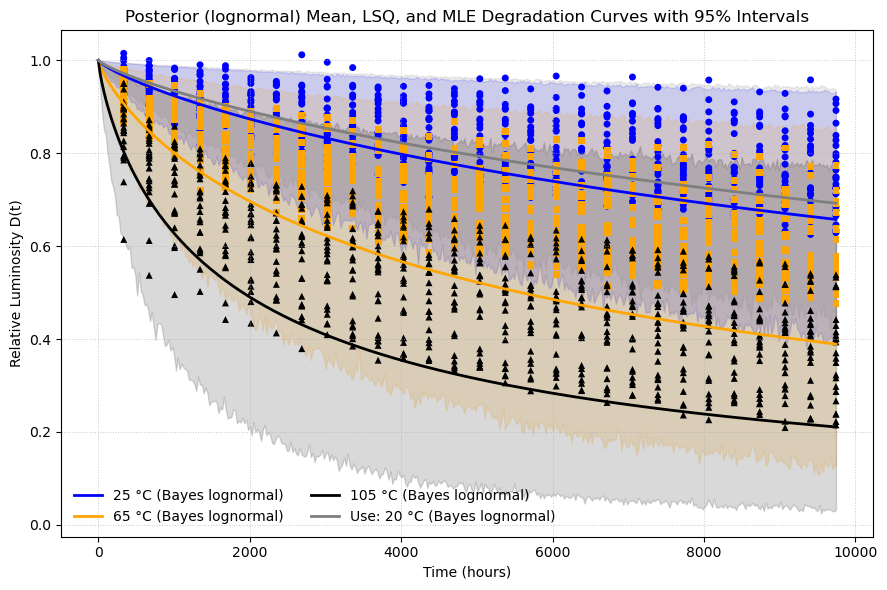

In [10]:
# 4) Parameter estimate validation visualization (Lognormal errors; constant CV)
# -----------------------------------------------------------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

# Temperatures to plot (°C) and color scheme
use_C = T_use - 273.15
plot_temps_C = [25.0, 65.0, 105.0] 
_plot_temps_C = [25.0, 65.0, 105.0, use_C]  # include use temperature
plot_colors  = {25.0: 'blue', 65.0: 'orange', 105.0: 'black', 30.0: 'red'}

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0  = g0_s[sel]
_g1  = g1_s[sel]
_Ea  = Ea_s[sel]
_tau = tau_s[sel]     # <-- lognormal log-sd draws (replaces _sig)

fig, ax = plt.subplots(figsize=(9, 6))

# # --- LSQ point-estimate degradation curves (solid) ---
# for Tc_lsq in plot_temps_C:
#     color_lsq = TEMP_COLORS.get(Tc_lsq, 'tab:gray')
#     T_eval_lsq = Tc_lsq + 273.15
#     mu_lsq = mu_D([gamma0_hat, gamma1_hat, Ea_hat], t_grid, T_eval_lsq)
#     ax.plot(t_grid, mu_lsq, linestyle='-', linewidth=1, color=color_lsq, label=f"{int(Tc_lsq)} °C (LSQ)")

# # --- MLE point-estimate degradation curves (dash-dot) ---
# for Tc_mle in plot_temps_C:
#     color_mle = TEMP_COLORS.get(Tc_mle, 'tab:gray')
#     T_eval_mle = Tc_mle + 273.15
#     mu_mle = mu_D([g0_mle, g1_mle, Ea_mle], t_grid, T_eval_mle)
#     ax.plot(t_grid, mu_mle, linestyle='-.', linewidth=2, color=color_mle, label=f"{int(Tc_mle)} °C (MLE)")

# --- Posterior mean and 95% intervals (parameter + predictive) ---
for Tc in _plot_temps_C:
    T_eval = Tc + 273.15
    accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))       # (ns, 1)
    # After sampling: compute mu_y_draws(t) as usual
    mu_y_draws = (1 + _g0[:,None]*(t_grid[None,:]*accel)**_g1[:,None])**(-1)   # your model
    mu_y_mean = mu_y_draws.mean(axis=0)
    # Map to damage scale, draw lognormal noise there, and invert:
    mu_R_draws = -np.log(mu_y_draws)
    eps = rng.normal(loc=-(0.5*(_tau[:,None]**2)), scale=_tau[:,None], size=mu_R_draws.shape)
    R_pred = mu_R_draws * np.exp(eps)
    y_pred = np.exp(-R_pred)                      # back to performance ∈ (0,1)
    
    lo_pred, hi_pred = np.quantile(y_pred, [0.1, 0.9], axis=0)

    color = TEMP_COLORS.get(Tc, 'tab:gray')
    label = f"{int(Tc)} °C (Bayes lognormal)" if Tc != use_C else f"Use: {int(use_C)} °C (Bayes lognormal)"

    # Plot the posterior mean curve
    ax.plot(t_grid, mu_y_mean, color=color, linewidth=2, label=label)

    # Show predictive band as a light fill (now asymmetric)
    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)

# --- Overlay scatter data points ---
for temp_c, gtemp in _df.sort_values(['Temp_C', 'unit', 'time_hr']).groupby('Temp_C'):
    color  = TEMP_COLORS.get(temp_c, 'tab:gray')
    marker = TEMP_MARKERS.get(temp_c, 'o')
    ax.scatter(gtemp['time_hr'].values, gtemp['D'].values, s=25, marker=marker, edgecolors='none', color=color)

# --- Final plot styling ---
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Relative Luminosity D(t)')
ax.set_title('Posterior (lognormal) Mean, LSQ, and MLE Degradation Curves with 95% Intervals')
ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
ax.legend(frameon=False, ncol=2, loc='best')
plt.tight_layout()
plt.show()


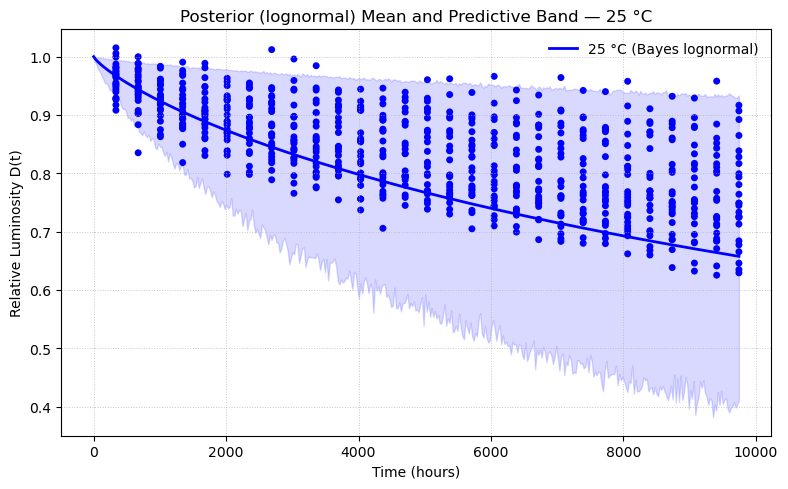

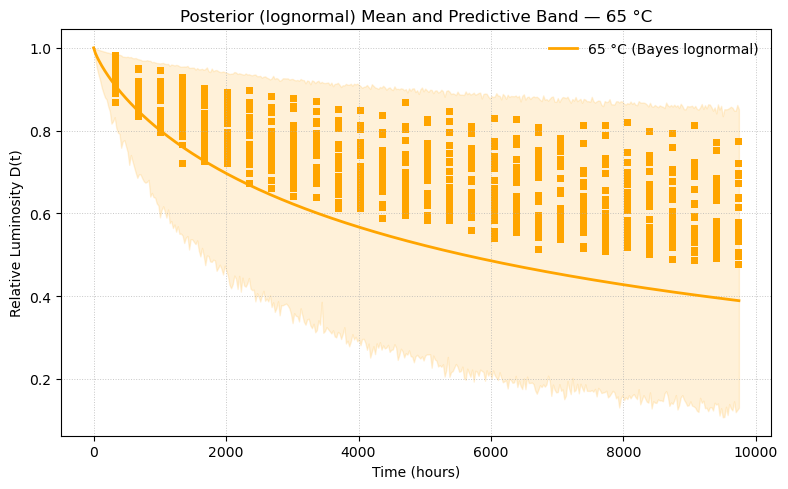

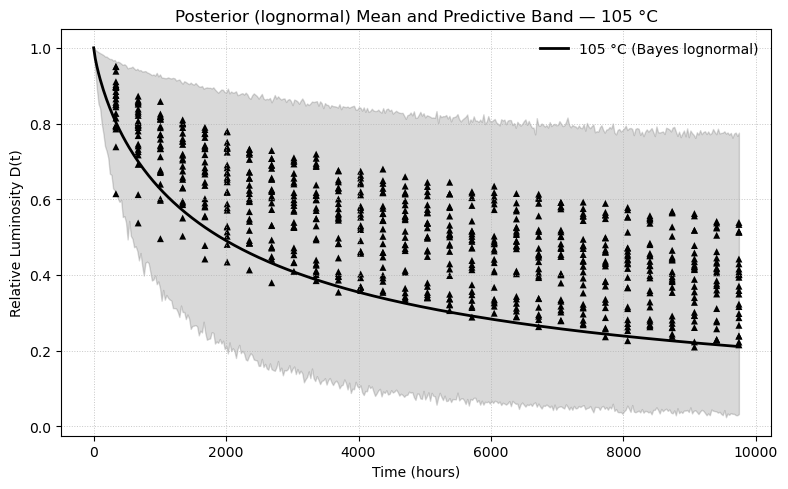

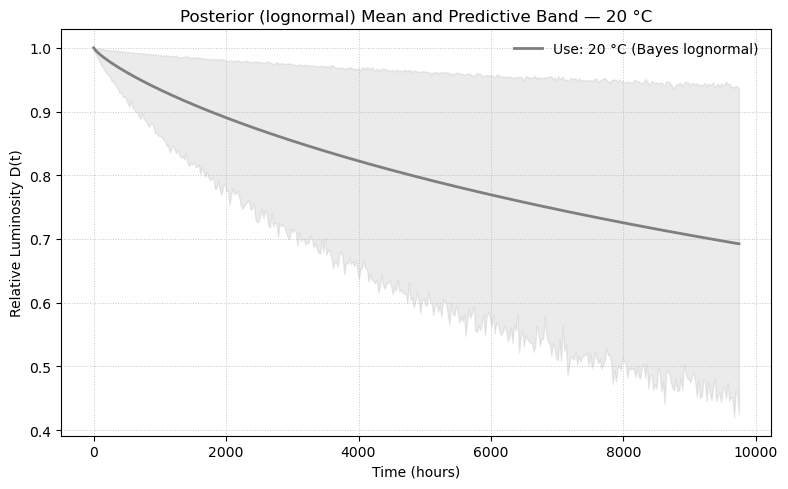

In [8]:
# 4) Parameter estimate validation visualization (Lognormal errors; constant CV)
# -----------------------------------------------------------------------------

# Time grid for smooth curves
t_grid = np.linspace(0.0, np.max(t_time), 400)

# Temperatures to plot (°C)
use_C = T_use - 273.15
plot_temps_C = [25.0, 65.0, 105.0] 
_plot_temps_C = [25.0, 65.0, 105.0, use_C]  # include use temperature

# Randomly thin posterior draws for computational efficiency
rng = np.random.default_rng(7)
ns = min(2000, len(g0_s))
sel = rng.choice(len(g0_s), size=ns, replace=False)
_g0  = g0_s[sel]
_g1  = g1_s[sel]
_Ea  = Ea_s[sel]
_tau = tau_s[sel]     # lognormal log-sd draws

# --- Loop over each temperature group and make a separate figure ---
for Tc in _plot_temps_C:
    fig, ax = plt.subplots(figsize=(8, 5))
    T_eval = Tc + 273.15
    accel = np.exp(_Ea[:, None] / K_eV_perK * (1.0 / T_use - 1.0 / T_eval))  # (ns, 1)

    # Compute posterior mean degradation model
    mu_y_draws = (1 + _g0[:, None] * (t_grid[None, :] * accel)**_g1[:, None])**(-1)
    mu_y_mean  = mu_y_draws.mean(axis=0)

    # Predictive simulation on R scale and invert back to D(t)
    mu_R_draws = -np.log(mu_y_draws)
    eps = rng.normal(loc=-(0.5*(_tau[:, None]**2)), scale=_tau[:, None], size=mu_R_draws.shape)
    R_pred = mu_R_draws * np.exp(eps)
    y_pred = np.exp(-R_pred)

    lo_pred, hi_pred = np.quantile(y_pred, [0.1, 0.9], axis=0)

    # Color and labels
    color = TEMP_COLORS.get(Tc, 'tab:gray')
    label = f"{int(Tc)} °C (Bayes lognormal)" if Tc != use_C else f"Use: {int(use_C)} °C (Bayes lognormal)"

    # Posterior mean and 80% predictive band
    ax.plot(t_grid, mu_y_mean, color=color, linewidth=2, label=label)
    ax.fill_between(t_grid, lo_pred, hi_pred, alpha=0.15, color=color, label=None)

    # Overlay scatter data for this temperature
    if Tc in _df['Temp_C'].unique():
        gtemp = _df[_df['Temp_C'] == Tc].sort_values(['unit', 'time_hr'])
        marker = TEMP_MARKERS.get(Tc, 'o')
        ax.scatter(gtemp['time_hr'], gtemp['D'], s=25, marker=marker, edgecolors='none', color=color)

    # Figure formatting
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Relative Luminosity D(t)')
    ax.set_title(f'Posterior (lognormal) Mean and Predictive Band — {int(Tc)} °C')
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
    ax.legend(frameon=False, loc='best')
    plt.tight_layout()
    plt.show()



Posterior summary for TTF (hr):
------------------------------------------------------------
Mean life at use conditions: 85,938 hr
Median life:                 75,726 hr
95% HDI:                 [19,224, 174,889] hr
95% ETI:                 [28,465, 201,481] hr
------------------------------------------------------------


c:\users\leaat\reliability\reliability\Fitters.py:440: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 8000/0 (0% right censored) 

   Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu    Sigma      Lambda  Log-likelihood   AICc    BIC       AD optimizer
   Lognormal_2P                                                                         11.2377 0.496327                    -95648.7 191301 191315 0.667478       TNC
   Lognormal_3P                       0                                                 11.2377 0.496327                    -95648.7 191303 191324 0.667478       TNC
 Loglogistic_3P 70882.1 3.29723 4800.14                                                                                     -95685.1 191376 191397    3.864       TNC
 Loglogistic_2P 75975.5 3.54708                                                                                             -95690.9 191386 191400  3.84859       TNC
       Gamma_3P 24587.8 3.04457 11078.4                         

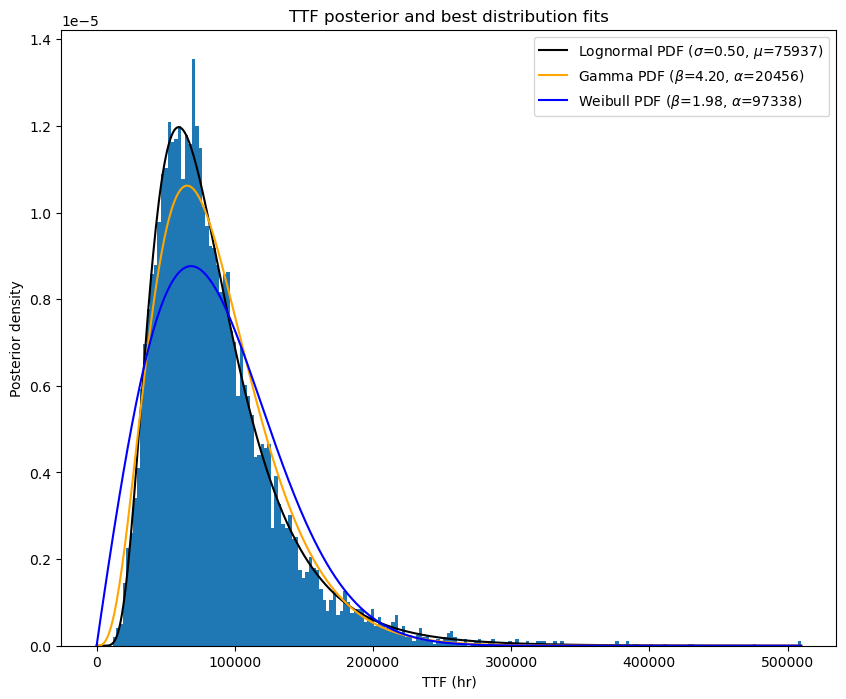

In [9]:
# 5) Posterior TTF PDF visualization
# --------------------------------

def _G_draw_factory(g0, g1, Ea, sig, Df, T_eval):
    """Return G_draw(t) = P{TTF <= t | params}, including Gaussian error."""
    accel = np.exp(Ea / K_eV_perK * (1.0/T_use - 1.0/T_eval))
    def G_draw(t):
        mu = (1.0 + g0 * (t * accel)**g1)**(-1.0)
        z  = (Df - mu) / sig
        return norm.cdf(z)
    return G_draw

def _suggest_t_hi(g0, g1, Df, mult=10.0):
    """Use deterministic crossing as a starting upper bracket for t."""
    rhs = (1.0 / Df) - 1.0
    # guard rails
    g0 = max(g0, 1e-30); g1 = max(g1, 1e-12)
    t_det = (rhs / g0)**(1.0 / g1)
    t_det = np.clip(t_det, 1e-9, 1e12)
    return float(mult * t_det)

def _grow_bracket(G_draw, u, t_hi0, t_hi_max=1e12):
    """Grow t_hi until G_draw(t_hi) >= u (or we give up)."""
    t_hi = max(1.0, t_hi0)
    val = G_draw(t_hi)
    it = 0
    while val < u and t_hi < t_hi_max and it < 60:
        t_hi *= 2.0
        val = G_draw(t_hi)
        it += 1
    return t_hi if val >= u else np.nan

def draw_ttf_with_error(g0_s, g1_s, Ea_s, sig_s, Df, T_eval, n_samps=5000, seed=4):
    """
    Invert per-draw CDF with brentq: sample u~U(0,1), solve G_draw(t)=u.
    Returns array of TTF samples (seconds/hours same as your t units).
    """
    rng = np.random.default_rng(seed)
    n_draws = len(g0_s)
    idx = rng.integers(low=0, high=n_draws, size=n_samps)  # sample posterior draws (with replacement)

    out = []
    for i in idx:
        g0, g1, Ea, sig = g0_s[i], g1_s[i], Ea_s[i], sig_s[i]
        G_draw = _G_draw_factory(g0, g1, Ea, sig, Df, T_eval)
        u = rng.random()

        # If already failed at t=0 (rare but possible with large sigma), return 0
        if G_draw(0.0) >= u:
            out.append(0.0)
            continue

        # bracket high end
        t_hi0 = _suggest_t_hi(g0, g1, Df, mult=10.0)
        t_hi  = _grow_bracket(G_draw, u, t_hi0)
        if not np.isfinite(t_hi):
            # last resort: try a very large bracket
            t_hi = _grow_bracket(G_draw, u, 1.0)
            if not np.isfinite(t_hi):
                # skip pathological draw
                continue

        # root find
        try:
            t = brentq(lambda t: G_draw(t) - u, 0.0, t_hi, maxiter=200)
            if np.isfinite(t) and t >= 0:
                out.append(t)
        except ValueError:
            # No sign change / numerical issues: skip this sample
            continue

    return np.asarray(out)

# --- Sample TTF PDF ---

Df = 0.50
T_eval = T_use
ttf_err = draw_ttf_with_error(g0_s, g1_s, Ea_s, sig_s, Df, T_eval, n_samps=8000, seed=24)

# --- Print results ---
def summarize_ttf(samples, hdi_prob=0.95, label="TTF (hr)", unit_label="hr"):
    s = np.asarray(samples)
    s = s[np.isfinite(s)]
    mean   = float(s.mean())
    median = float(np.median(s))
    lo, hi = az.hdi(s, hdi_prob=hdi_prob)  # Highest Density Interval
    # Equal-tailed interval too (optional)
    eti_lo, eti_hi = np.percentile(s, [(1-hdi_prob)/2*100, (1-(1-hdi_prob)/2)*100])
    print(f"\nPosterior summary for {label}:\033[0m")
    print("-" * 60)
    print(f"Mean life at use conditions: {mean:,.0f} {unit_label}")
    print(f"Median life:                 {median:,.0f} {unit_label}")
    print(f"{int(hdi_prob*100)}% HDI:                 [{lo:,.0f}, {hi:,.0f}] {unit_label}")
    print(f"{int(hdi_prob*100)}% ETI:                 [{eti_lo:,.0f}, {eti_hi:,.0f}] {unit_label}")
    print("-" * 60)
    return {"mean": mean, "median": median, "hdi": (float(lo), float(hi)), "eti": (float(eti_lo), float(eti_hi))}

summary = summarize_ttf(ttf_err, hdi_prob=0.95, label="TTF (hr)")

# Find best parameters for each Dist
Best_fit = Fit_Everything(failures=ttf_err, show_histogram_plot=False, show_probability_plot=False, show_PP_plot=False, show_best_distribution_probability_plot=False)

# Generate x-values for plotting
x = np.linspace(0.01, np.max(ttf_err), 500)

# Calculate the most common PDFs for visual comparrison 
W_pdf = weibull_min.pdf(x, c=Best_fit.Weibull_2P_beta, scale=Best_fit.Weibull_2P_alpha)
G_pdf = gamma.pdf(x, a=Best_fit.Gamma_2P_beta, scale=Best_fit.Gamma_2P_alpha, loc=0)
L_pdf = lognorm.pdf(x, s=Best_fit.Lognormal_2P_sigma, scale=np.exp(Best_fit.Lognormal_2P_mu), loc=0)

# Plot the PDF
plt.figure(figsize=(10, 8))
plt.hist(ttf_err, bins=200, density=True)
plt.plot(x, L_pdf, c="black", label=fr'Lognormal PDF ($\sigma$={Best_fit.Lognormal_2P_sigma:.2f}, $\mu$={np.exp(Best_fit.Lognormal_2P_mu):.0f})')
plt.plot(x, G_pdf, c="orange", label=fr'Gamma PDF ($\beta$={Best_fit.Gamma_2P_beta:.2f}, $\alpha$={Best_fit.Gamma_2P_alpha:.0f})')
plt.plot(x, W_pdf, c="blue", label=fr'Weibull PDF ($\beta$={Best_fit.Weibull_2P_beta:.2f}, $\alpha$={Best_fit.Weibull_2P_alpha:.0f})')
plt.xlabel("TTF (hr)")
plt.ylabel("Posterior density")
plt.title("TTF posterior and best distribution fits")
plt.legend()
plt.show()

### A note on reporting Bayesian Credible Interval results:

- Use the Highest Density Interval (HDI) when the posterior is skewed or non-Gaussian — it better reflects where the parameter “likely is.

- Use the Equal-Tailed Interval (ETI) if you want a simple and comparable percentile-based summary (or if your posterior is roughly symmetric).

| Interval Type | Meaning                                             | Suitable For                     | Width          | Computation                    | Typical Symbol              |
| ------------- | --------------------------------------------------- | -------------------------------- | -------------- | ------------------------------ | --------------------------- |
| **HDI**       | Smallest region containing X% posterior probability | Skewed or multimodal posteriors  | Narrowest      | Needs density sorting or ArviZ | often used for Bayesian CrI |
| **ETI**       | Equal probability in both tails                     | Symmetric or unimodal posteriors | Slightly wider | Simple percentiles             | –                           |
